Link to the notebook: https://colab.research.google.com/drive/1qPxV3BqCBKopvnGk2iH1YdN-3kTgvEoO?usp=sharing

In [ ]:
# Download the file to drive
!gdown 'https://drive.google.com/uc?id=1k7QmTjzk4hFrAnO_x8YvndoWyZ2H_LZw'

In [ ]:
# Unzip the file
!unzip DataC3FM95282020.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change working directory
import os
os.chdir('/content/drive/My Drive/Banking_CW3')
!pwd

/content/drive/My Drive/Banking_CW3


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

# 1. Logitstic regression
## Identify the train/test sample at area level

According to the data floder with images, we first identify the train/test sample at area level based on their filenames.

In [ ]:
# Read the data
loans = pd.read_csv('DefaultRiskperArea.csv')

In [ ]:
import os

train0_path = 'Data/train/0'
train1_path = 'Data/train/1'
test0_path = 'Data/test/0'
test1_path = 'Data/test/1'

# Store the image file names in a list
train_filename = [f for f in os.listdir(train0_path)] + [f for f in os.listdir(train1_path)]
test_filename = [f for f in os.listdir(test0_path)] + [f for f in os.listdir(test1_path)]

In [ ]:
import re

# Extract areas from the file names
train_area = [re.search('Area(.*)_', fname).group(1) for fname in train_filename]
test_area = [re.search('Area(.*)_', fname).group(1) for fname in test_filename]

In [ ]:
# Get the unique areas from two lists of areas
train_area_unq = list(set(train_area))
test_area_unq = list(set(test_area))

We can see from below that the intersection between these two sets are empty, which means that no areas are in both the training set and testing set.

In [ ]:
# Check if any area is in both train and test
len(set(train_area_unq).intersection(set(test_area_unq)))

0

Then we split the structured data into train and test by their corresponding areas.

In [ ]:
# Split the structured data into train and test
loans_train = loans.loc[loans['Area_Number'].isin(train_area_unq)]
loans_test = loans.loc[loans['Area_Number'].isin(test_area_unq)]

## Create a model

Before fitting the logistic regression model, we first normalize the data using a z-transform.

In [ ]:
# Normalize the data
from scipy.stats import zscore
loans_train_nor = pd.concat([loans_train.iloc[:,:12].apply(zscore), loans_train['BinaryDefault']], axis=1)
loans_test_nor = pd.concat([loans_test.iloc[:,:12].apply(zscore), loans_test['BinaryDefault']], axis=1)

Next, we fit a logistic regression model with no penalty using the training set.

In [ ]:
from sklearn.linear_model import LogisticRegression

loans_logreg = LogisticRegression(penalty='none', # Type of penalization l1 = lasso, l2 = ridge
                                     #C = loans_logreg.C_[0], # The optimal LASSO parameter
                                     tol=0.001, # Tolerance for parameters
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251061267, # Random seed
                                     max_iter=200, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'newton-cg', # How to optimize.
                                     n_jobs = 1,      # Processes to use. Set to number of physical cores.
                                     warm_start = True
                                    )

In [ ]:
loans_logreg.fit(X = loans_train_nor.iloc[:, :-1], # All rows and from the second var to end
                    y = loans_train_nor['BinaryDefault'] # The target
                   )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=1, penalty='none',
                   random_state=251061267, solver='newton-cg', tol=0.001,
                   verbose=1, warm_start=True)

The coefficients of this model are shown below.

In [ ]:
# Model coefficients
coef_df = pd.concat([pd.DataFrame({'column': loans_train_nor.columns[:-1]}),
                    pd.DataFrame(np.transpose(loans_logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,fico,-0.148200
1,mi_pct,-0.016791
2,cnt_units,0.220387
3,cltv,5.828907
4,ltv,-5.650831
5,cnt_borr,0.077678
6,occpy_sts_S,0.468062
7,channel_C,-0.211828
8,channel_T,0.448768
9,prop_type_MH,0.034270


In [ ]:
# Intercept
loans_logreg1.intercept_

array([-0.01262056])

## Model Performance

After that, we apply the fitted model to the testing set and eveluate the model performance using the confusion matrix and the ROC curve.

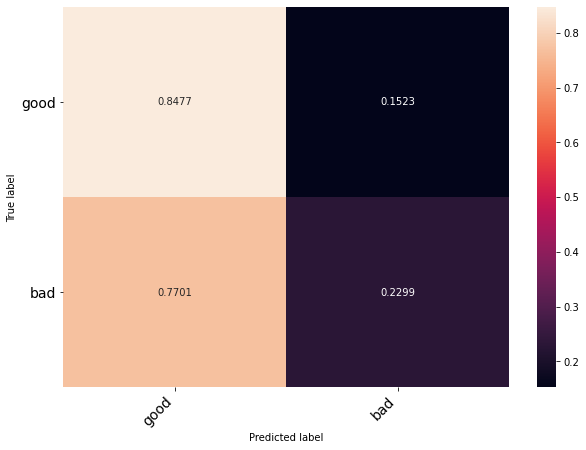

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Calculate probability
pred_class_test = loans_logreg.predict(loans_test_nor.iloc[:, :-1])
probs_test = loans_logreg.predict_proba(loans_test_nor.iloc[:, :-1])
probs_test = probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_lr = confusion_matrix(y_true = loans_test_nor['BinaryDefault'],
                    y_pred = pred_class_test)

# Turn matrix to percentages
confusion_matrix_lr = confusion_matrix_lr.astype('float') / confusion_matrix_lr.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_lr, index=['good', 'bad'], columns=['good', 'bad'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.4f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

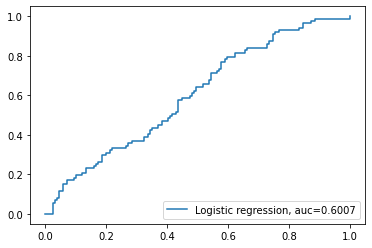

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(loans_test_nor['BinaryDefault'], probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = loans_test_nor['BinaryDefault'],
                             y_score = probs_test),
              decimals = 4)

# Create and show the plot
plt.plot(fpr,tpr,label="Logistic regression, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 2. Deep learning model

## Model training

We use the *ResNet152* model to train a deep learning model using only the images.

In [ ]:
import h5py
import PIL

In [ ]:
from tensorflow.keras.applications import ResNet152
model_rn = ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

After importing the model from the tensorflow package, we add some dense layers for predictions.

In [ ]:
from tensorflow.keras.layers import *
headModel = model_rn.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [ ]:
from tensorflow.keras import Model
model_img = Model(inputs=model_rn.input, outputs=headModel)

The model summary is shown below:

In [ ]:
model_img.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=1e-5, decay=(1e-5) / 10)
model_img.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[tf.keras.metrics.AUC()]
              )

Next, we prepare the images such that they can be used for training.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
# prepare data augmentation configuration. One for train, one for test.
train_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                         # NNets like small inputs. Rescale.
                                  shear_range=0.2,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # Resnet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                       # NNets like small inputs. Rescale.
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                  # Flip horizontally?
                                  vertical_flip=False,                    # Flip vertically?
                                  preprocessing_function=preprocess_input,# Resnet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0                    # No validation cut for test.
                                  )


# We will use a batch size of 64. Depends on RAM of GPU.
batch_size = 32

# Train data generator. We point to the training directory!
train_data_dir = 'Data/train'

# VGG requires 224 x 224 images.
(img_height, img_width) = (224, 224)

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='binary',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'training',                 # What subset to use?
                                                    shuffle = True                       # Shuffle the data?
                                                    )

validation_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='binary',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'validation',               # What subset to use?
                                                    shuffle = True                       # Shuffle the data?
                                                    )

# Test data generator.
test_data_dir = 'Data/test'
test_generator = test_datagen.flow_from_directory(
                                                  test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle = False
                                                  )

Found 3988 images belonging to 2 classes.
Found 996 images belonging to 2 classes.
Found 2142 images belonging to 2 classes.


Then we can train the model with prepared data.

In [ ]:
# Number of epochs
epochs = 10

# Train!
model_img.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            initial_epoch = 0,
            steps_per_epoch = 62*2, # Train cases / batch size = 62
            validation_steps = 15*2 # Validation cases / batch_size = 15.
          )

Epoch 1/10
124/124 [==============================] - 150s 1s/step - loss: 1.1207 - auc_11: 0.5249 - val_loss: 0.9667 - val_auc_11: 0.5140
Epoch 2/10
124/124 [==============================] - 150s 1s/step - loss: 0.7903 - auc_11: 0.5770 - val_loss: 1.3337 - val_auc_11: 0.5121
Epoch 3/10
124/124 [==============================] - 152s 1s/step - loss: 0.7002 - auc_11: 0.6026 - val_loss: 0.7583 - val_auc_11: 0.5146
Epoch 4/10
124/124 [==============================] - 152s 1s/step - loss: 0.6446 - auc_11: 0.6472 - val_loss: 0.9179 - val_auc_11: 0.5018
Epoch 5/10
124/124 [==============================] - 152s 1s/step - loss: 0.6255 - auc_11: 0.6632 - val_loss: 0.9166 - val_auc_11: 0.5385
Epoch 6/10
124/124 [==============================] - 152s 1s/step - loss: 0.6145 - auc_11: 0.6824 - val_loss: 0.7192 - val_auc_11: 0.5293
Epoch 7/10
124/124 [==============================] - 153s 1s/step - loss: 0.5760 - auc_11: 0.7304 - val_loss: 0.6867 - val_auc_11: 0.5666
Epoch 8/10
124/124 [=======

In [ ]:
loss = model_img.history.history['metric']
val_loss = model_img.history.history['val_metric']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Applying the model
Next, we use the trained model to make predictions on the testing set.

In [ ]:
# Applying to the test set with a generator.
test_generator.reset()

# Get probabilities
output = model_img.predict(test_generator)
labels = test_generator.classes

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(labels, output[:,0])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = labels,
                             y_score = output[:,0]),
              decimals = 4)

# Create and show the plot
plt.plot(fpr,tpr,label="ResNet152, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# Save the model
model_img.save('Resnet152_a.h5')

In [ ]:
model_img = keras.models.load_model('Resnet101.h5')

# 3. Multimodal Learning
## Combining the structured data with the path of image data

Before constructing the multimodal deep learning model, we first need to combine the structured inputs and the path of images into one dataframe.

In [ ]:
loans = pd.read_csv('DefaultRiskperArea.csv')

In [ ]:
train0_path = 'Data/train/0'
train1_path = 'Data/train/1'
test0_path = 'Data/test/0'
test1_path = 'Data/test/1'

# Get the path of all the images
train_filename1 = [os.path.join(train0_path, f) for f in os.listdir(train0_path)] + [os.path.join(train1_path, f) for f in os.listdir(train1_path)]
test_filename1 = [os.path.join(test0_path, f) for f in os.listdir(test0_path)] + [os.path.join(test1_path, f) for f in os.listdir(test1_path)]
filename = train_filename1 + test_filename1

In [ ]:
# Match the path with structured data according to the area number
import re
loans['path'] = [[fname for fname in filename if (re.search('Area(.*)_', fname).group(1)+ '.0') == str(area_num)] for area_num in loans.Area_Number]

In [ ]:
# Explode the path such that each row has only one path
loans = pd.DataFrame({
          col:np.repeat(loans[col].values, loans['path'].str.len())
          for col in loans.columns.difference(['path'])
      }).assign(**{'path':np.concatenate(loans['path'].values)})[loans.columns.tolist()]

Similarly, we split the data into train and test according to the area number.

In [ ]:
# Split the structured data into train and test
loans_train = loans.loc[loans['Area_Number'].isin(train_area_unq)]
loans_test = loans.loc[loans['Area_Number'].isin(test_area_unq)]

Then we normalize the data into the interval [0, 1] since we need to have small inputs for the neural network.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()
Scaler.fit(loans_train.iloc[:,:12])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
loans_train.iloc[:,:12] = Scaler.transform(loans_train.iloc[:,:12])
loans_test.iloc[:,:12] = Scaler.transform(loans_test.iloc[:,:12])

In [ ]:
loans_train.drop(['Area_Number'], axis=1, inplace=True)
loans_test.drop(['Area_Number'], axis=1, inplace=True)

## Construct the model

After that, we can construct the multimodal deep learning model as follow.

In [ ]:
# Parameters
ImageSize = (224,224)
BatchSize = 32

import tensorflow as tf
from tensorflow.keras.layers import *
image_input = tf.keras.Input(shape=ImageSize + (3,), name = 'image_input')

# Load an empty ResNet101
from tensorflow.keras.applications import ResNet152
rn_input = ResNet152(weights='imagenet', include_top=False)

# Use the model API to attach it to our input layer.
ImageClassifier = rn_input(image_input)

# Add a Flatten layer with the model API.
ImageClassifier = Flatten()(ImageClassifier)

# Now we create the structured data layer.
predictive_features = 12
features_input  = keras.Input(shape=(predictive_features,), name="structured_data")
Structured =  Dense(8, activation = 'relu' )(features_input) # Add one processing layer
Structured =  Dropout(0.5)(Structured)   # Dropout after  Dense
Structured =  Dense(4, activation = 'relu' )(Structured) # Add one processing layer
Structured =  Dropout(0.5)(Structured)   # Dropout after  Dense

# Merge all available features into a single large vector via concatenation
merged = concatenate([ImageClassifier, Structured])

# Add a few prediction layers
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.5)(merged)

loans_multi = Dense(1, activation='sigmoid', name="loans_multi")(merged)

# Instantiate an end-to-end model predicting house_prices
multimodal_model = keras.Model(inputs=[image_input, features_input],
                               outputs=[loans_multi])

In [ ]:
multimodal_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
structured_data (InputLayer)    [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            104         structured_data[0][0]            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8)            0           dense[0][0]                      
______________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=1e-5, decay=(1e-5) / 10)
from tensorflow.keras import optimizers
multimodal_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[tf.keras.metrics.AUC()]
              )

The model we construct can be visualized in the following plot.

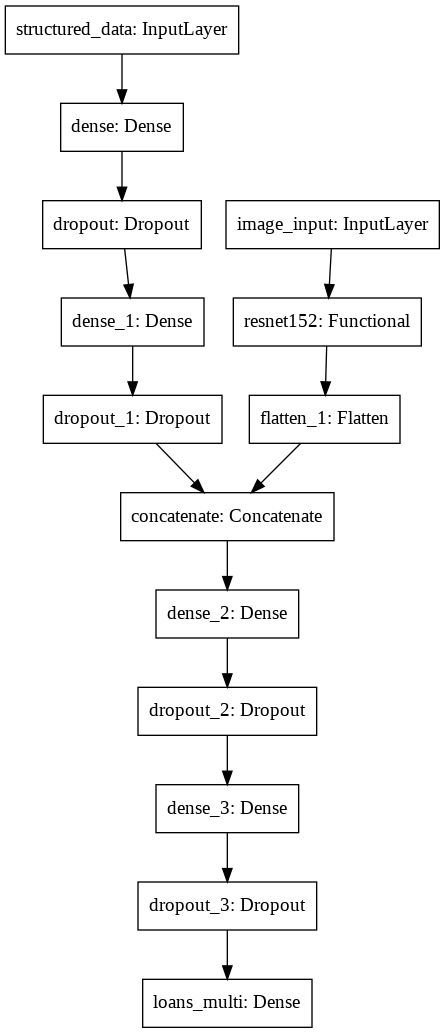

In [ ]:
import pydot as pyd
from tensorflow.keras.utils import plot_model

#Visualize Model
plot_model(
          multimodal_model, to_file='model.png', show_shapes=False, show_layer_names=True,
          rankdir='TB', expand_nested=False, dpi=96
          )

## Model fitting

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
# prepare data augmentation configuration. One for train, one for test.
train_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                         # NNets like small inputs. Rescale.
                                  shear_range=0.2,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # Resnet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                       # NNets like small inputs. Rescale.
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                  # Flip horizontally?
                                  vertical_flip=False,                    # Flip vertically?
                                  preprocessing_function=preprocess_input,# Resnet expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0                    # No validation cut for test.
                                  )

In [ ]:
# Define parameters

target_size = (224, 224)
batch_size = 32

# What are the useful columns? Note the position of the target.
pred_cols = np.r_[0:13]

# We only modify the generators. Note the y vector.
train_generator = train_datagen.flow_from_dataframe(loans_train,
                                                    directory='.',
                                                    x_col='path',
                                                    y_col=loans_train.columns[pred_cols],
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='training',
                                                    interpolation="bilinear"
                                                   )

validation_generator = train_datagen.flow_from_dataframe(loans_train,
                                                    directory='.',
                                                    x_col='path',
                                                    y_col=loans_train.columns[pred_cols],
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    interpolation="bilinear"
                                                   )

test_generator = train_datagen.flow_from_dataframe(loans_test,
                                                    directory='.',
                                                    x_col='path',
                                                    y_col=loans_test.columns[pred_cols],
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='raw',
                                                    subset='training',
                                                    interpolation="bilinear"
                                                   )

# Define combined generator
def train_generator_func():
    count = 0

    while True:
        if  count == len(loans_train.index):
            train_generator.reset()
            break
        count += 1
        data = train_generator.next()

        # Let's identify where is what.
        target_location = 12
        predictive_columns = np.r_[0:12]

        # Now we reshape everything. First the images.
        imgs = data[0]
        # Now we need to extract which ones are the predictive variables.
        cols = data[1][:, predictive_columns]
        # Finally we need the targets.
        targets = data[1][:, target_location]
        yield [imgs, cols], targets


def validation_generator_func():
    count = 0
    while True:
        if count == len(loans_train.index):
            validation_generator.reset()
            break
        count += 1
        data = validation_generator.next()

        # Let's identify where is what.
        target_location = 12
        predictive_columns = np.r_[0:12]

        # Now we reshape everything. First the images.
        imgs = data[0]
        # Now we need to extract which ones are the predictive variables.
        cols = data[1][:, predictive_columns]
        # Finally we need the targets.
        targets = data[1][:, target_location]
        yield [imgs, cols], targets


def test_generator_func():
    count = 0
    test_generator.reset()
    while True:
        if count == len(loans_test.index):
            test_generator.reset()
            break
        count += 1
        data = test_generator.next()

        # Let's identify where is what.
        target_location = 12
        predictive_columns = np.r_[0:12]

        # Now we reshape everything. First the images.
        imgs = data[0]
        # Now we need to extract which ones are the predictive variables.
        cols = data[1][:, predictive_columns]
        # Finally we need the targets.
        targets = data[1][:, target_location]
        yield [imgs, cols], targets

Found 3988 validated image filenames.
Found 996 validated image filenames.
Found 1714 validated image filenames.


In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
multimodal_model.fit(train_generator_func(),
                      epochs=10,
                      initial_epoch = 0,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=validation_generator_func(),
                      validation_steps=validation_steps
                     )

## Applying to the testing set

In [ ]:
# Calculate outputs in test set
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

loans_result = multimodal_model.predict(test_generator_func(),
                                    steps=STEP_SIZE_TEST+1,
                                    verbose=1)

54/54 [==============================] - 49s 898ms/step


In [ ]:
labels = test_generator.labels[:,12]
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(labels, loans_result)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = labels,
                             y_score = loans_result),
              decimals = 4)

# Create and show the plot
plt.plot(fpr,tpr,label="Multimodal, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# Save the model
multimodal_model.save('multimodal.h5')